# Building Models for the Cave


## Re-setting the stage

The Weedle's Cave dataset is a set containing, on the one hand the combatants and results of 50,000 Pokémon battles, and on the other the base stats/basic information for each kind of Pokémon. Our goal is to predict the results of future combats. In [a previous notebook](https://github.com/aldozironi/OnlineCourses/blob/master/Python_4_Data_Science_Edx/FinalProject/2018-06-03-Entering_The_Cave.ipynb) we delved deeper into the context of the problem and performed the basic data exploration for this dataset.

Armed with the knowledge we obtained then, we're ready to start looking for models capable of predicting victories in Pokémon battles.

## Processing the data

In the aforementioned notebook we discovered that we had to process the data as follows: 

* The data comes from two databases, combats.csv and pokemon.csv, and that we need to perform a merge of the two tables twice: once to obtain the stats of the Pokémon with the first turn and another one for the second Pokémon to act.
* Some column names in pokemon.csv include special characters, so we decided to clean them up.
* There's a null value in the column "Name" of pokemon.csv; we infered it's value is 'Primeape'.
* Pokémon types are strings, and we'd rather have them as binary (is Pokémon x of type y).
* There are some duplicated rows in combats.csv, which we decided to remove when modelling.
* We want to use a binary target variable (whether the first acting Pokémon won or not), which we have to generate based on the Winner column.

The only transformation we didn't cover previously is the transformation of the type from string to categorical. The way the type system works is that each Pokémon and each ability has at least one type (abilities have only exactly one); and each type has a set of types against which it's strong and another set againts which it's weak. When a Pokémon gets hit by an attack, the type of the attack gets checked against the Pokemon's types. If the attack is strong against one of the Pokemon's types, it deals extra damage; if it's weak, it deals reduced damage. Therefore, we're not interested in the ordering of the types of the Pokémon, i.e., what's it's first and second type, but rather, what the type(s) ofthe Pokémon are.

To transform the Type_1 and Type_2 columns into features, we'll create a boolean column for each of the 18 types, where a 1 will represent that the Pokémon is of the type indicated by the column name.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pylab as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

In [2]:
path = # path to data files

In [3]:
# Read combat data.
combat_data = pd.read_csv(path + 'combats.csv')
# Remove the duplicates from the data set.
combat_data = combat_data.drop_duplicates()

# Read stats data.
poke_data = pd.read_csv(path + 'pokemon.csv')
# Fix missing name.
poke_data.loc[poke_data['#']==63,'Name'] = 'Primeape'
# Rename columns.
colname_dict = {'#': 'Number',
                'Type 1': 'Type_1',
                'Type 2': 'Type_2',
                'Sp. Atk': 'Sp_Atk',
                'Sp. Def':'Sp_Def'}
poke_data = poke_data.rename(columns=colname_dict)

# Create type columns. Remember that we know that the type information is clean and consistent.
# For each of the Pokémon types.
for typ in poke_data.Type_1.append(poke_data.loc[poke_data.Type_2.notnull(),'Type_2']).unique().tolist():
    poke_data['is_'+typ] = False # Create a column for the type with default value of 0 (not of the type).
    cond = (poke_data.Type_1 == typ) | (poke_data.Type_2 == typ) # Pokémon that are of that type.
    poke_data.loc[cond,'is_'+typ] = True # Overwrite the value for Pokémon of the type.
    
# Merge stat data for first Pokémon.
full_data = combat_data.merge(poke_data, how='left',left_on='First_pokemon',right_on='Number')
# Merge stat data for second Pokémon.
full_data = full_data.merge(poke_data, how='left',left_on='Second_pokemon',
                            right_on='Number',suffixes=('_first','_second'))

# Drop repeat columns (we already knew the number of the first and second Pokémon).
full_data = full_data.drop('Number_first',axis=1)
full_data = full_data.drop('Number_second',axis=1)
# Remove Type columns
full_data = full_data.drop('Type_1_first',axis=1)
full_data = full_data.drop('Type_2_first',axis=1)
full_data = full_data.drop('Type_1_second',axis=1)
full_data = full_data.drop('Type_2_second',axis=1)

# Create the target variable, which we'll call "y".
full_data['y'] = full_data.Winner == full_data.First_pokemon
full_data['y'] = full_data.y.astype(int)

# Remove original data from memory
del combat_data
del poke_data

# Sanity check.
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48048 entries, 0 to 48047
Data columns (total 58 columns):
First_pokemon         48048 non-null int64
Second_pokemon        48048 non-null int64
Winner                48048 non-null int64
Name_first            48048 non-null object
HP_first              48048 non-null int64
Attack_first          48048 non-null int64
Defense_first         48048 non-null int64
Sp_Atk_first          48048 non-null int64
Sp_Def_first          48048 non-null int64
Speed_first           48048 non-null int64
Generation_first      48048 non-null int64
Legendary_first       48048 non-null bool
is_Grass_first        48048 non-null bool
is_Fire_first         48048 non-null bool
is_Water_first        48048 non-null bool
is_Bug_first          48048 non-null bool
is_Normal_first       48048 non-null bool
is_Poison_first       48048 non-null bool
is_Electric_first     48048 non-null bool
is_Ground_first       48048 non-null bool
is_Fairy_first        48048 non-null bo

## A model as is:

First, we'll check how well a logistic model fits the data to get an idea of how long we've still to go.

In [4]:
def test_model(model, data, target, features=None, random_state=42, test_size=0.3, verbose=False):
    """
    Function to test a Scikit-Learn classification model. It generates a train/test split, fits a model
    and uses it to predict the test. It prints the accuracy and the confusion matrix.
    :param model: Model object to use. It can be any SciKit-Learn classifier or any model with a sklearn-like wrapper.
    :param data: DataFrame with the features and the target.
    :param target: String with the name of the column in data that's the target variable.
    :param features: List of column names to use as features. By default it'll take all non-target columns as features.
    :param random_state: Integer with the random state to use in the train/test split. Default is 42.
    :param test_size: Float with the proportion of test size.
    :param verbose: Boolean with the verbosity of the function.
    """
    # Turn an empty feature list to None.
    if isinstance(features,list):
        if len(features)==0:
            features=None
    # Set default of all non-target variables as features.
    if not features:
        features = [col for col in data.columns]
        features.remove(target)
    if verbose:
        print('Features in model: ' + str(features))
        print('Generating test/train split.')

    # Generate train/test split.
    X = data[features].values
    y = data[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        random_state=random_state,
                                                        test_size=test_size)

    # Small correction in case of using a single feature.
    if len(features) == 1:
        X_test = X_test.reshape(-1,1)
        X_train = X_train.reshape(-1,1)
    
    # Train model.
    if verbose:
        print('Fitting model.')
    model.fit(X_train,y_train)
    if verbose:
        print('Finished fitting.')
        
    # Predict y_test with the model.
    y_hat = model.predict(X_test)
    
    # Outputs: Printing accuracy and the confusion matrix.
    print('Accuracy: ' + str(accuracy_score(y_pred=y_hat,y_true=y_test))+'\n')
    print(confusion_matrix(y_pred=y_hat,y_true=y_test))

In [5]:
basic_features = [col for col in full_data.columns.tolist()]
basic_features.remove('Name_first')
basic_features.remove('Name_second')
basic_features.remove('First_pokemon')
basic_features.remove('Second_pokemon')
basic_features.remove('Winner')
basic_features.remove('y')

log = LogisticRegression()
test_model(model=log, data=full_data, target='y', features=basic_features)

Accuracy: 0.8879639264654874

[[6850  809]
 [ 806 5950]]


A 'vanilla' model seems to perform very well, so our feature just need to learn (hopefully) the 11% missing.

## Feature engineering and selection

To build features, we'll try several transformations of the stats (Attack, Defense, Sp_Atk, Sp_Def and Speed) and use boxplots to see if its distribution is different in the 1s and 0s (indicating that the feature might be useful to learn the winner of a combat). Then, we'll build a logistic regression model using only that feature and look at its significance and predicting power to select whether it should be part of the final model.

**Notes:**
1. Remember that the dataset has 47% of ones, so our current benchmark is guessing all results as 0 and getting an accuracy of 53%. We'll also test the change in accuracy when adding the feature to the base result obtained using the basic features (88%).
2. In order to make the notebook readable, we won't show all features we try; instead, we'll only display some interesting ones and report the results for all attempts below.

In [6]:
def test_feature(x):
    """
    Function that tests the performance of feature x in a logistic regression under the following metrics:
        1. Accuracy in a model using it as the only feature,
        2. Accuracy in a model using the basic features,
    It also displays a boxplot of the feature against the target
    :param x: String with the name of the column to use as a feature
    """
    # Make boxplot of the feature vs the target.
    full_data.boxplot(by='y',column=x, figsize=(17, 8), vert=False)

    # Instance a Logistic Regression model.
    log = LogisticRegression()
    
    # A model with x as the only feature.
    print('Behaviour of ' + x)
    test_model(model=log, data=full_data, features=[x], target='y')
    
    # Model with the casic features and x.
    log = LogisticRegression()
    print('\nIn a model with basic_features:')
    test_model(model=log, data=full_data, features=basic_features + [x], target='y')

In [7]:
# Create features
# The first Pokémon to act is the one with the highest speed, so if the second one has a higher Speed stat,
# it must be of lower level and thus, weaker.
full_data['Speed_diff'] = full_data.Speed_second / full_data.Speed_first
# How hard does the first Pokémon strike with when using special?
full_data['Sp_Punch_first'] = full_data.Sp_Def_second / full_data.Sp_Atk_first
# How hard does the second Pokémon strike with when using special?
full_data['Sp_Punch_second'] = full_data.Sp_Def_first / full_data.Sp_Atk_second
# How hard does the first Pokémon strike with when using normal attack?
full_data['Punch_first'] = full_data.Defense_second / full_data.Attack_first
# How hard does the second Pokémon strike with when using normal attack?
full_data['Punch_second'] = full_data.Defense_first / full_data.Attack_second
# How hard can the first Pokémon hit?
full_data['Pwr_Punch_first'] = full_data.Sp_Punch_first + full_data.Punch_first
# What's the difference in damage outputs?
full_data['Damage_diff'] = (full_data.Sp_Punch_second + full_data.Punch_second) / (full_data.Sp_Punch_first + full_data.Punch_first)

Behaviour of Speed_diff
Accuracy: 0.9028789455428373

[[6561 1098]
 [ 302 6454]]

In a model with basic_features:
Accuracy: 0.8888657648283038

[[6887  772]
 [ 830 5926]]


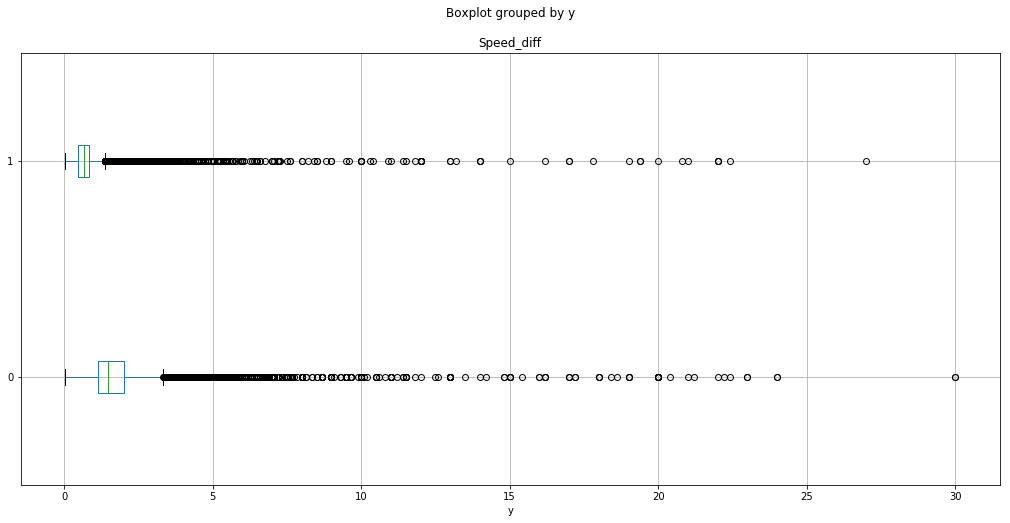

In [8]:
test_feature('Speed_diff')

Behaviour of Punch_first
Accuracy: 0.5991675338189386

[[4495 3164]
 [2614 4142]]

In a model with basic_features:
Accuracy: 0.8890045091918141

[[6852  807]
 [ 793 5963]]


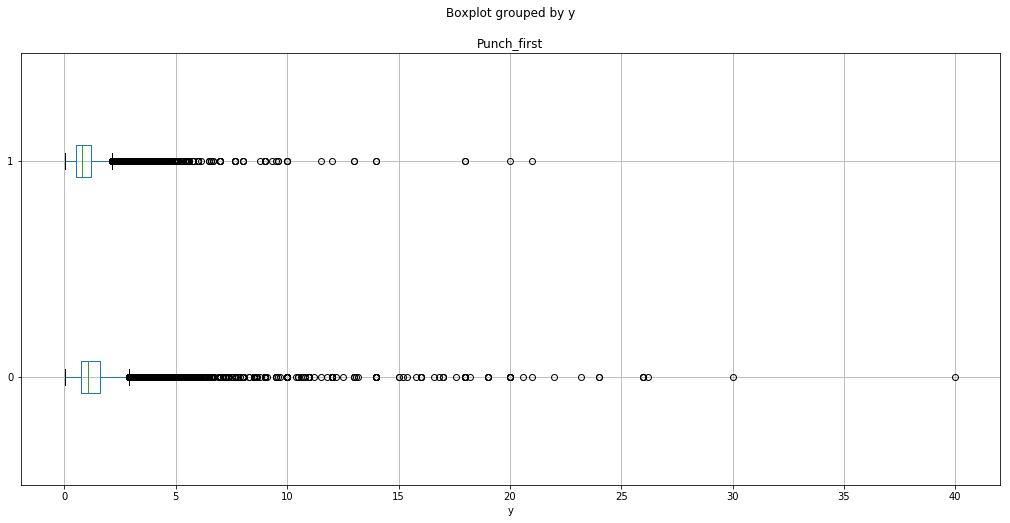

In [9]:
test_feature('Punch_first')

**Results:**


|Feature | Accuracy by itself (%)| Accuracy with basic features (%)|
|--------|----:----|----:----|
|Speed_diff| 90.29|88.86|
|Damage_diff|64.43|88.86|
|Pwr_Punch_first|63.19|88.83|
|Sp_Punch_second|62.31|88.80|
|Sp_Punch_first|62.13|88.86|
|Punch_first|59.92|88.91|
|Punch_second|59.45|88.74|

1. First, we note that the Speed Differential is a very important feature due to how a simple linear model that uses only that regressor has over 90% accuracy.
2. None of the other features is amazing by itself, but they all help predict the outcome.
3. At this point we can start thinking about model complexity. With our results so far, we might be able to capture with just a few features who will winn a Pokémon battle.

### Testing a complete model

First, to test our capabilities, we'll build model using each feature we have.

In [10]:
built_features = ['Speed_diff', 'Damage_diff', 'Pwr_Punch_first',
                  'Sp_Punch_second', 'Sp_Punch_first', 'Punch_first', 'Punch_second']
features = basic_features + built_features
log = LogisticRegression()
test_model(model=log, data=full_data, target='y', features=features)

Accuracy: 0.8909469302809573

[[6910  749]
 [ 823 5933]]


**Results:** Interestingly, we get slightly worse performance with the complete model than that with only the Speed_diff feature. This indicates that there's a lot of redundant information captured by the features. Now, we'll remove the features that provide resundant information. Also, notice how we get basically the same performance with the full model as we do with a model using only the basic features and the Punch_first feature. Therefore, we can use a model with the basic features and the Punch_first feature as a benchmark.

### Selecting the best features

There are two ways in which we could try to refine the basic features, dropping those that don't add much information by checking their p-values; however, given the fact that the accuracy with the complete model and the model using the basic features and the Punch_first feature, I think it's sufficient to say that the result of a Pokémon battle is defined by their types, stats, and how hard the first one hits when using a normal attack (defined as the ratio of the second Pokémon's defense and the first Pokémon's attack).

Alternatively, the winner of the battle is defined by how much faster is the second Pokémon. 

The fact that we have two different views and when we use both we don't get a boost in performance or the same performance as using only one leads me to suspect that both approaches make different predictions for some of the battles.

We'll try to see how much the two models differ in opinions and in how many places one is right and the other one is wrong.

In [11]:
selected_features = ['Punch_first']
full_features = basic_features + selected_features

# Get fixed train/test datasets.
X = full_data.drop('y', axis=1).drop('Name_first',axis=1).drop('Name_second',axis=1)
X = X.drop('First_pokemon',axis=1).drop('Second_pokemon',axis=1).drop('Winner',axis=1)
y= full_data.y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3)

# Model for just speed feature.
log = LogisticRegression()
log.fit(X_train.Speed_diff.values.reshape(-1, 1),y_train.values)
y_hat = log.predict(X_test.Speed_diff.values.reshape(-1, 1))
results = pd.DataFrame(y_hat,columns=['speed']).reset_index()
# Full model.
log = LogisticRegression()
log.fit(X_train[full_features].values,y_train.values)
y_hat = log.predict(X_test[full_features].values)
results = results.merge(pd.DataFrame(y_hat, columns=['full']).reset_index(), on='index')

# Clean up the results.
results = results.drop('index',axis=1)
# Add true values.
results['y_true'] = y_test.values

results = results.astype(bool)


# Check differences
print('Number of true zeros: ' + str(sum(results.y_true==0)))
print('Number of true ones: ' + str(sum(results.y_true==1)))
print('Cases when both predicted 0: ' + str(sum( (results.speed==0) & (results.full==0) )))
print('Cases where both predicted 0 correctly: ' + str(sum( (results.speed==0) & (results.full==0) & (results.y_true==0) )))
print('Cases when both predicted 1: ' + str(sum( (results.speed==1) & (results.full==1) )))
print('Cases where both predicted 1 correctly: ' + str(sum( (results.speed==1) & (results.full==1) & (results.y_true==1) )))
print('Cases where speed predicted 0 correctly but full predicted 1: ' + str(sum( (results.speed==0) & (results.full==1) & (results.y_true==0) )))
print('Cases where speed predicted 1 correctly but full predicted 0: ' + str(sum( (results.speed==1) & (results.full==0) & (results.y_true==1) )))
print('Cases where full predicted 0 correctly but speed predicted 1: ' + str(sum( (results.speed==1) & (results.full==0) & (results.y_true==0) )))
print('Cases where full predicted 1 correctly but speed predicted 0: ' + str(sum( (results.speed==0) & (results.full==1) & (results.y_true==1) )))

Number of true zeros: 7659
Number of true ones: 6756
Cases when both predicted 0: 6715
Cases where both predicted 0 correctly: 6418
Cases when both predicted 1: 6623
Cases where both predicted 1 correctly: 5959
Cases where speed predicted 0 correctly but full predicted 1: 143
Cases where speed predicted 1 correctly but full predicted 0: 495
Cases where full predicted 0 correctly but speed predicted 1: 434
Cases where full predicted 1 correctly but speed predicted 0: 5


**Results:** We note that although both models predicted many cases correctly (which was expected, given that they both have an accuracy of close to 90%), there are some notable differences in the types of errors each model makes. Particularly, it seems like the speed model is better at predicting 1; whereas the full model is better at predicting 0.

## Looking outside the logistic model

So far we've only used the logistic regression to try to find what features are important to determining the winners of Pokémon battles, and, although the results are good, we might be able to get better results by trying more complex algorithms.

**Notes:**
1. Since the Speed_diff feature seems to capture something different to the features in the full model, we'll use the Speed_diff feature along with the ones in the full model in our experiments.
2. We'll use the same train/test split we used in the previous section.
3. We'll only focus on the most powerful algorithms for each model paradigm because they have a lot of parameters to fine-tune, which we'll need to perform. The selected algorithms are:

  * Decision Trees: XGBoost (Extremely Parallelized Gradient Boosted Decision Trees).
  * Support Vector Machines: Linear-SVM (Linear-Support Vector Machine).

### Sanity check: Testing both models with default parameters

In [12]:
features = full_features + ['Speed_diff']
X_train = X_train[features]
X_test = X_test[features]

In [13]:
print('XGBoost model performance:')
xgb = XGBClassifier(max_depth=3,
                    learning_rate=.1,
                    n_estimators=100,
                    gamma=0,
                    reg_alpha=0,
                    reg_lambda=1)
test_model(model=xgb,features=features,data=full_data,target='y')

print('\nSVM model performance:')
lsvm = LinearSVC(penalty='l2',
                 tol=1e-4,
                 C=1.0)
test_model(model=lsvm,features=features,data=full_data,target='y')

XGBoost model performance:


/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.954006243496358

[[7237  422]
 [ 241 6515]]

SVM model performance:
Accuracy: 0.7449878598681928

[[4234 3425]
 [ 251 6505]]


Note that we got a huge increase in accuracy using XGBoost. SVMs don't seem as interesting right now.

### Hyperparameter tunning

Now we can run some tests to try to get the best parameters for each model. We'll use a grid search to look for the parameters, i.e., we'll define ranges for the parameters and check each combination in the grid.

#### Linear-SVM

In [14]:
# Define ranges to search
penalty_rage = ['l1','l2']
C_range = range(1,100,10)

#Initialize results dataframe
hyp_results_lsvm = pd.DataFrame()
for (penalty,C) in [(penalty,C) for penalty in penalty_rage for C in C_range]:
    
    # If the penalty is the l_1-norm, we need to use dual = False
    if penalty == 'l1':
        dual = False
    else:
        dual = True   
    
    #Initialize the model with selected parameters
    lsvm = LinearSVC(penalty=penalty,C=C,dual=dual)
    # Obtain the accuracy of the model
    lsvm.fit(X_train,y_train)
    y_hat = lsvm.predict(X_test)
    acc = accuracy_score(y_pred=y_hat,y_true=y_test)
    
    # Update results DataFrame
    aux = pd.DataFrame(index=[penalty+'-'+str(C)],columns=['penalty','C','acc'])
    aux.loc[penalty+'-'+str(C),'penalty'] = penalty
    aux.loc[penalty+'-'+str(C),'C'] = C
    aux.loc[penalty+'-'+str(C),'acc'] = acc
    hyp_results_lsvm = hyp_results_lsvm.append(aux)
hyp_results_lsvm.to_pickle('results_lsvm.p')

,penalty,C,acc
l1-11,l1,11,0.886022
l1-71,l1,71,0.886022
l1-81,l1,81,0.886022


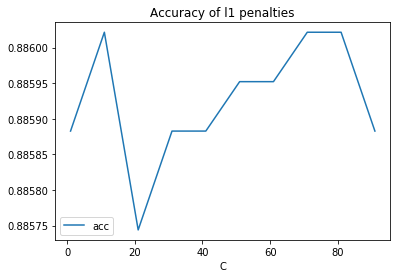

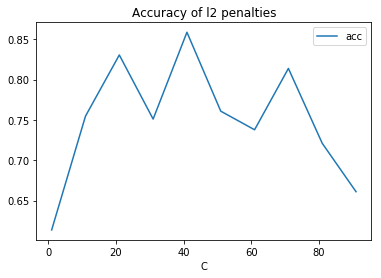

In [15]:
hyp_results_lsvm[hyp_results_lsvm.penalty=='l1'].plot(x='C',y='acc',title='Accuracy of l1 penalties')
hyp_results_lsvm[hyp_results_lsvm.penalty=='l2'].plot(x='C',y='acc',title='Accuracy of l2 penalties')
hyp_results_lsvm[hyp_results_lsvm.acc == hyp_results_lsvm.acc.max()]

#### XGBoost

Since XGBoost has a lot of parameters, we'll look for optima on several iterations:
1. First, we'll vary the regularization parameters, reg_alpha and reg_lambda. This will, in theory, give us the best framing of the model.
2. We'll vary the maximum depth and number of estimators to find the best ensemble of trees to solve the problem.

This may seem like a roundabout way to getting to an optimum that might not be global, but it'll gve us a better understanding of the problem and its solution.

A first run for values of reg_alpha and reg_lambda between 1 and 91 showed that the lower the regularizing values, the better the accuracy, so we'll run a grid on small values.

In [17]:
# Define ranges to search
alpha_range = range(0,50,5)
lambda_range = range(0,50,5)

#Initialize results dataframe
hyp_results_xgb = pd.DataFrame()

for (reg_alpha,reg_lambda) in [(reg_alpha,reg_lambda) for reg_alpha in alpha_range for reg_lambda in lambda_range]:
    
    # Divide the reg_alpha and reg_lambda by 10
    reg_alpha = reg_alpha/10.
    reg_lambda = reg_lambda/10.
    
    #Initialize the model with selected parameters
    xgb = XGBClassifier(max_depth=3,
                        learning_rate=.1,
                        n_estimators=100,
                        gamma=0,
                        reg_alpha=reg_alpha,
                        reg_lambda=reg_lambda)
    # Obtain the accuracy of the model
    xgb.fit(X_train,y_train)
    y_hat = xgb.predict(X_test)
    acc = accuracy_score(y_pred=y_hat,y_true=y_test)
    
    # Update results DataFrame
    aux = pd.DataFrame(index=[str(reg_alpha)+'-'+str(reg_lambda)],columns=['reg_alpha','reg_lambda','acc'])
    aux.loc[str(reg_alpha)+'-'+str(reg_lambda),'reg_alpha'] = reg_alpha
    aux.loc[str(reg_alpha)+'-'+str(reg_lambda),'reg_lambda'] = reg_lambda
    aux.loc[str(reg_alpha)+'-'+str(reg_lambda),'acc'] = acc
    hyp_results_xgb = hyp_results_xgb.append(aux)
hyp_results_xgb.to_pickle('xgb_results_p1.p')

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

In [18]:
hyp_results_xgb = hyp_results_xgb.astype(float)

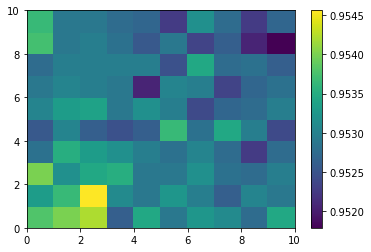

In [29]:
pl.figure()
pivot_results = hyp_results_xgb.pivot(columns='reg_alpha',index='reg_lambda',values='acc')
pl.pcolor(pivot_results)
pl.colorbar()

The previous plot shows the behaviour of the accuracy as the reg_alpha and reg_lambda change. Note it's a very flat surface, so almost any value in the grid is a good starting point for these parameters. Let's use:
* reg_alpha = 1.5, and
* reg_lambda = 1.5.

Now, let's look at the max_depth and n_estimators parameters.

In [30]:
# Define ranges to search
max_depth_range = range(1,20,3)
n_estimators_range = range(50,550,50)

#Initialize results dataframe
hyp_results_xgb = pd.DataFrame()

for (max_depth,n_estimators) in [(max_depth,n_estimators) for max_depth in max_depth_range for n_estimators in n_estimators_range]:
    
    #Initialize the model with selected parameters
    xgb = XGBClassifier(max_depth=max_depth,
                        learning_rate=.1,
                        n_estimators=n_estimators,
                        gamma=0,
                        reg_alpha=1.5,
                        reg_lambda=1.5)
    
    # Obtain the accuracy of the model
    xgb.fit(X_train,y_train)
    y_hat = xgb.predict(X_test)
    acc = accuracy_score(y_pred=y_hat,y_true=y_test)
    
    # Update results DataFrame
    aux = pd.DataFrame(index=[str(max_depth)+'-'+str(n_estimators)],columns=['max_depth','n_estimators','acc'])
    aux.loc[str(max_depth)+'-'+str(n_estimators),'max_depth'] = max_depth
    aux.loc[str(max_depth)+'-'+str(n_estimators),'n_estimators'] = n_estimators
    aux.loc[str(max_depth)+'-'+str(n_estimators),'acc'] = acc
    hyp_results_xgb = hyp_results_xgb.append(aux)
hyp_results_xgb.to_pickle('xgb_results_p2.p')

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size 

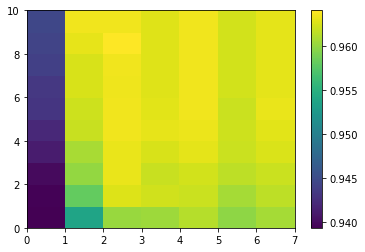

In [32]:
hyp_results_xgb = hyp_results_xgb.astype(float)

pl.figure()
pl.pcolor(hyp_results_xgb.pivot(columns='max_depth',index='n_estimators',values='acc'))
pl.colorbar()

It seems like we should use a max_depth between 7 and 13 and the number of estimators aren't particularly relevant as long as they're above 100 and below 500. We'll select the following values:
* max_depth: 7
* n_estimators: 200

Therefore, our final XGBoost Model is:

In [46]:
xgb = XGBClassifier(max_depth=7,
                    learning_rate=.1,
                    n_estimators=200,
                    gamma=0,
                    reg_alpha=1.5,
                    reg_lambda=1.5)

# Obtain the accuracy of the model
xgb.fit(X_train,y_train)
y_hat = xgb.predict(X_test)
accuracy_score(y_pred=y_hat,y_true=y_test)

/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9632327436697884

**Results:**
1. Even after optimiziing hyperparameters for L-SVM, the accuracy didn't improve with respect to the benchmarks (full model & speed model). The l2 penalty in this method makes the accuracy vary wildly when we vary the value of C; which isn't true for l1 penalties. In fact, C parameter makes basically no difference in this case (the curve of the accuracy value when the parameter C varies is flat).
2. The XGBoost model is very good at predicting winners, specially after tunning the parameters.

## Conclusions

We began our exploration with the two following main questions in mind.

1. What are the characteristics that define the winner of a Pokémon fight?
2. Can we build a model capable of predicting the results of Pokémon fights?

After covering a lot of ground performing tasks that included data processing to generate the type feature(s), engineering features, testing models and hyperparameter tunning, we can give answers to the previous questions. In order:

1. The most important features when predicting winners are the types of the Pokémon, their base stats, what's the normal damage output of the first Pokémon (defined as the ratio of the second Pokémon's defense to the first Pokémons attack) and the speed of the second Pokémon as a proportion of the speed of the first one (this latter is a proxy for the level difference of the fighters).
2. Yes. In fact, we generated four different models, two using logistic regression (but on different features), one using SVMs and one using XGBoost. Of these, XGBoost provides the best accuracy (close to 96%).

## Next Steps

There are two main lines in which we could continue our analysis of the Weedle's cave dataset.

* First, we could try to gain more insights on what defines the winner of a battle. This would inlude performing a more in-depth analysis of the interactions between features and interpretting the XGBoost model (which is not an easy task to do, but we could follow the roadmap in [this article](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27).)

* Second, we could try to improve the models either by engineering other features or by using other modelling techniques, like deep learning or model stacking.

Naturally, both lines feed off of one another. Clearly, learning insights from the data can yield better features, and creating (and analyzing) new models can lead to new insights. After all, data science is an iterative process of learning.

## Appendix A: Model Playground

For simplicity, we include the code necessary to run tests on the final models. The following code is designed to be self contained, so that none of the previous cells have to be executed in order to simplyfy the testing process. An idea of what tests to run would be to define several random states and check the mean and standard deviation of the accuracy of a model over those random states to check how stable the models are.

In [2]:
path = #Path to data files.

In [3]:
# ---------------------- Set Up ---------------------- #
# # # # Importing libraries
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pylab as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

# # # # Data process
# Read combat data.
combat_data = pd.read_csv(path + 'combats.csv')
# Remove the duplicates from the data set.
combat_data = combat_data.drop_duplicates()

# Read stats data.
poke_data = pd.read_csv(path + 'pokemon.csv')
# Fix missing name.
poke_data.loc[poke_data['#']==63,'Name'] = 'Primeape'
# Rename columns.
colname_dict = {'#': 'Number',
                'Type 1': 'Type_1',
                'Type 2': 'Type_2',
                'Sp. Atk': 'Sp_Atk',
                'Sp. Def':'Sp_Def'}
poke_data = poke_data.rename(columns=colname_dict)

# Create type columns. Remember that we know that the type information is clean and consistent.
# For each of the Pokémon types.
for typ in poke_data.Type_1.append(poke_data.loc[poke_data.Type_2.notnull(),'Type_2']).unique().tolist():
    poke_data['is_'+typ] = False # Create a column for the type with default value of 0 (not of the type).
    cond = (poke_data.Type_1 == typ) | (poke_data.Type_2 == typ) # Pokémon that are of that type.
    poke_data.loc[cond,'is_'+typ] = True # Overwrite the value for Pokémon of the type.
    
# Merge stat data for first Pokémon.
full_data = combat_data.merge(poke_data, how='left',left_on='First_pokemon',right_on='Number')
# Merge stat data for second Pokémon.
full_data = full_data.merge(poke_data, how='left',left_on='Second_pokemon',
                            right_on='Number',suffixes=('_first','_second'))

# Drop repeat columns (we already knew the number of the first and second Pokémon).
full_data = full_data.drop('Number_first',axis=1)
full_data = full_data.drop('Number_second',axis=1)

# Build features.
full_data['Speed_diff'] = full_data.Speed_second / full_data.Speed_first
full_data['Punch_first'] = full_data.Defense_second / full_data.Attack_first

# Create the target variable, which we'll call "y".
full_data['y'] = full_data.Winner == full_data.First_pokemon
full_data['y'] = full_data.y.astype(int)

# Remove unwanted columns.
full_data = full_data.drop('Type_1_first',axis=1)
full_data = full_data.drop('Type_2_first',axis=1)
full_data = full_data.drop('Type_1_second',axis=1)
full_data = full_data.drop('Type_2_second',axis=1)
full_data = full_data.drop('Winner',axis=1)
full_data = full_data.drop('Name_first',axis=1)
full_data = full_data.drop('Name_second',axis=1)

# Remove original data from memory.
del combat_data
del poke_data

# # # # Testing function
def test_model(model, data, target, features=None, random_state=42, test_size=0.3, verbose=False):
    """
    Function to test a Scikit-Learn classification model. It generates a train/test split, fits a model
    and uses it to predict the test. It prints the accuracy and the confusion matrix.
    :param model: Model object to use. It can be any SciKit-Learn classifier or any model with a sklearn-like wrapper.
    :param data: DataFrame with the features and the target.
    :param target: String with the name of the column in data that's the target variable.
    :param features: List of column names to use as features. By default it'll take all non-target columns as features.
    :param random_state: Integer with the random state to use in the train/test split. Default is 42.
    :param test_size: Float with the proportion of test size.
    :param verbose: Boolean with the verbosity of the function.
    :return: Float with the accuracy score for the model
    """
    # Turn an empty feature list to None.
    if isinstance(features,list):
        if len(features)==0:
            features=None
    # Set default of all non-target variables as features.
    if not features:
        features = [col for col in data.columns]
        features.remove(target)
    if verbose:
        print('Features in model: ' + str(features))
        print('Generating test/train split.')

    # Generate train/test split.
    X = data[features].values
    y = data[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        random_state=random_state,
                                                        test_size=test_size)

    # Small correction in case of using a single feature.
    if len(features) == 1:
        X_test = X_test.reshape(-1,1)
        X_train = X_train.reshape(-1,1)
    
    # Train model.
    if verbose:
        print('Fitting model.')
    model.fit(X_train,y_train)
    if verbose:
        print('Finished fitting.')
        
    # Predict y_test with the model.
    y_hat = model.predict(X_test)
    
    # Output: Accuracy score for the model.
    return accuracy_score(y_pred=y_hat,y_true=y_test)

# # # # Default models

# Logstic model
log = LogisticRegression()

# Support Vector Machines
svm = LinearSVC(penalty='l1',
                C=11,
                dual=False)

# XGBoost
xgb = XGBClassifier(max_depth=7,
                    learning_rate=.1,
                    n_estimators=200,
                    gamma=0,
                    reg_alpha=1.5,
                    reg_lambda=1.5)

# # # # Default features
basic_features = ['HP_first', 'Attack_first', 'Defense_first', 'Sp_Atk_first', 'Sp_Def_first',
                 'Speed_first', 'Generation_first', 'Legendary_first', 'is_Grass_first',
                 'is_Fire_first', 'is_Water_first', 'is_Bug_first', 'is_Normal_first',
                 'is_Poison_first', 'is_Electric_first', 'is_Ground_first', 'is_Fairy_first',
                 'is_Fighting_first', 'is_Psychic_first', 'is_Rock_first', 'is_Ghost_first',
                 'is_Ice_first', 'is_Dragon_first', 'is_Dark_first', 'is_Steel_first',
                 'is_Flying_first', 'HP_second', 'Attack_second', 'Defense_second', 
                 'Sp_Atk_second', 'Sp_Def_second', 'Speed_second', 'Generation_second',
                 'Legendary_second', 'is_Grass_second', 'is_Fire_second', 'is_Water_second',
                 'is_Bug_second', 'is_Normal_second', 'is_Poison_second', 'is_Electric_second',
                 'is_Ground_second', 'is_Fairy_second', 'is_Fighting_second',
                 'is_Psychic_second', 'is_Rock_second', 'is_Ghost_second', 'is_Ice_second',
                 'is_Dragon_second', 'is_Dark_second', 'is_Steel_second', 'is_Flying_second']

full_features = basic_features + ['Punch_first']

speed_features = ['Speed_diff']

svm_features = basic_features + ['Punch_first', 'Speed_diff']

xgb_features = basic_features + ['Punch_first', 'Speed_diff']

In [5]:
acc_full = test_model(model=log, data=full_data, target='y', features=full_features,
                      random_state=255, test_size=.33)
acc_speed = test_model(model=log, data=full_data, target='y', features=speed_features,
                       random_state=255, test_size=.33)
acc_svm = test_model(model=svm, data=full_data, target='y', features=svm_features,
                       random_state=255, test_size=.33)
acc_xgb = test_model(model=xgb, data=full_data, target='y', features=xgb_features,
                       random_state=255, test_size=.33)
print('Accuracy of full model: ' + str(acc_full))
print('Accuracy of speed model: ' + str(acc_speed))
print('Accuracy of lsvm model: ' + str(acc_svm))
print('Accuracy of xgb model: ' + str(acc_xgb))

Accuracy of full model: 0.8890010090817356
Accuracy of speed model: 0.9034434914228052
Accuracy of lsvm model: 0.8869197780020182
Accuracy of xgb model: 0.9622225025227044


/Users/Propietario/Desktop/Docs/Otros_Cursos/Python_4_Data_Science/python_4_data_science/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
